# Tennis Simulations

I'm a tennis fan (and player). Let's explore a few oddities of tennis scoring.

1. In a famous graduation speech at Dartmouth, recently retired tennis legend Roger Federer, pointed out that, over the course of his career, he won only 53% of the points he played. This seems kind of surprising, since he reached the finals, meaning he won six matches in a row, in 31 of 81 grand slams he competed in (38%). Did he just play a lot better in the grand slams, or is it plausible that he could have a high probability of winning matches even if he had only a slight edge on each point?

2. Some players are really dominant as servers, but not as good at returning. They seem to go tie-breaks a lot, with players alternating serve and the server always winning until they reach 6-6 and play a tiebreak. How big a discrepancy in server vs. return point winning percentage is needed to make this happen?

3. Commentators often talk about certain players being "clutch" or "choking" in high-pressure situations. How much of a difference in match results would it make if a player had a boost in performance on high-pressure points?

Along the way, we'll learn a little about simulation.

# The Tennis Scoring System


## Game Scoring

In standard scoring for a single game, the first player to get four points wins, but you have to win by two. For obscure historical reasons, the actual scoring looks more complicated:
- instead of counting 0-1-2-3, we count love-15-30-40. 
- At 40-40, we stop using numbers and just say "deuce" meaning the score is tied.
- From deuce, whoever wins the next point has the "advantage"; 
- if the player with advantage wins the next point, they win the game; otherwise it returns to deuce


## Winning a Set


A set consists of a sequence of games. The first person to win six games wins the set, but you have to win by two. If the score is tied at 6-6, the players play a "tie-break", with the winner taking the set.

The players alternate who serves on a game-by-game basis, not within each game. When a player is serving, they serve all the points in that game.

At the professional level, the server wins more games than the returner. A bit of terminology, if the server wins the game, it's called a "hold"; if the returner wins the game, it's called a "break".


## Winning a Match

At the professional level, a match is best-of-three-sets, meaning that the first player to win two sets wins. In the four most important tournaments of the year, the so-called Grand Slams, the men play best-of-five-sets, meaning that the first player to win three sets wins.


## Tie-break Scoring

In a tie-break, one player serves one point, the other player serves two points, and thereafter they switch servers every two points.

In a regular tie-break, the first player to reach 7 points wins, but you have to win by two. 

In a deciding-set tiebreak (tied at 1 set each in a regular tournament; tied at 2 sets each in a men's Grand Slam), the victor is the first player to reach 10 points; again, you have to win by two. Thus, it's possible for a tie-break to end with a very high score, like 16-14, if it keeps being tied at 7-7, 8-8, 9-9, etc.


## Winning a Tournament

On the professional tour, tournaments are conducted as single-elimination. In the grand slam tournaments, there are 128 players, so it requires seven rounds to determine a single champion. (In each round, half the players are eliminated; so after one round 64 players are left, after two 32 players are left, and so on. After seven rounds, only one player is left.)

# Simulating Tennis Points, Games, Sets, Matches, and Tournaments

Recall that a simulation involves two things:
- a model that captures some essential features of the real-world process, while omitting other details
- an execution of the model, often many times, to see what happens


### Modeling a Player

We will model a player as an instance of a `Player` class, with a few parameters:
- their service skill, with a range of -10 to +10
- their return skill, with a range of -10 to +10
- their clutch factor, with a range of -10 to +10

### Modeling a Point
We will model the outcome of a point with a function `simulate_point` that takes two players as input and returns the winner of the point. The function will use a random draw for a "Bernoulli" random variable. It's like a coin flip, but the probability of "heads" (the server winning the point) is not necessarily 50%.
- The probability of the server winning the point starts with a base probability of 0.5, to which we add the server's service skill and subtract the returner's return skill. 
  - If the point can decide the game, we also add the server's clutch factor and subtract the returner's clutch factor.
  - If it is a clutch game, we will also add the server's clutch factor and subtract the returner's clutch factor. 
  - The clutch factors could be added twice if it is a game point in a clutch game.

Note that each point is independent of all other points; if a player wins one point, it doesn't affect the probability of winning the next point, except if it gives someone a game point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [2]:
class Player:
    def __init__(self, serve_skill=0, return_skill=0, pressure_skill=0, name=None):
        self.serve_skill = serve_skill  # -10 to +10
        self.return_skill = return_skill  # -10 to +10
        self.pressure_skill = pressure_skill
        self.name = name or "Player"
    
    def __repr__(self):
        return f"{self.name}(serve={self.serve_skill}, return={self.return_skill}, pressure={self.pressure_skill})"

In [3]:
class Point:
    """Represents a single point in tennis."""
    
    def __init__(self, server: Player, returner: Player, is_game_point: bool = False, is_clutch_game: bool = False):
        self.server = server
        self.returner = returner
        self.is_game_point = is_game_point
        self.is_clutch_game = is_clutch_game
        self.probability = None  # Will be set during simulation
        self.server_won = None  # Will be set during simulation
    
    def calculate_probability(self):
        """Calculate the probability that the server wins this point."""
        prob = 50 + self.server.serve_skill - self.returner.return_skill
        
        # Apply pressure adjustments
        if self.is_game_point:
            prob += (self.server.pressure_skill - self.returner.pressure_skill)
        if self.is_clutch_game:
            prob += (self.server.pressure_skill - self.returner.pressure_skill)
        
        return np.clip(prob / 100, 0.0, 1.0)
    
    def simulate(self):
        """Simulate this point and store the result."""
        self.probability = self.calculate_probability()
        self.server_won = np.random.rand() < self.probability
        return self.server_won
    
    def __repr__(self):
        winner = self.server.name if self.server_won else self.returner.name
        return f"Point(winner={winner}, p={self.probability:.2f})"
    
    def display(self):
        """Display detailed information about this point."""
        result = "won" if self.server_won else "lost"
        pressure = ""
        if self.is_game_point:
            pressure += " [GAME POINT]"
        if self.is_clutch_game:
            pressure += " [CLUTCH GAME]"
        return f"{self.server.name} (S) vs {self.returner.name} (R) | p={self.probability:.2f} | {self.server.name} {result}{pressure}"


In [4]:
class Game:
    """Represents a tennis game."""
    
    def __init__(self, server: Player, returner: Player, is_clutch_game: bool = False):
        self.server = server
        self.returner = returner
        self.is_clutch_game = is_clutch_game
        self.points = []  # List of Point objects
        self.server_won = None
    
    def is_game_point(self, server_points, returner_points, points_to_win=4):
        """Check if the current point is a game point."""
        return (server_points >= points_to_win - 1 or returner_points >= points_to_win - 1) and server_points != returner_points
    
    def simulate(self):
        """Simulate this game and accumulate all points."""
        points_to_win = 4
        server_points = 0
        returner_points = 0
        
        while (server_points < points_to_win and returner_points < points_to_win) or abs(server_points - returner_points) < 2:
            is_gp = self.is_game_point(server_points, returner_points, points_to_win)
            point = Point(self.server, self.returner, is_gp, self.is_clutch_game)
            
            if point.simulate():
                server_points += 1
            else:
                returner_points += 1
            
            self.points.append(point)
        
        self.server_won = server_points > returner_points
        return self.server_won
    
    def get_score(self):
        """Get the point score at each stage of the game."""
        server_points = 0
        returner_points = 0
        scores = []
        
        for point in self.points:
            if point.server_won:
                server_points += 1
            else:
                returner_points += 1
            scores.append((server_points, returner_points))
        
        return scores
    
    def __repr__(self):
        winner = self.server.name if self.server_won else self.returner.name
        return f"Game(winner={winner}, points={len(self.points)})"
    
    def display(self, show_points=False):
        """Display game information."""
        winner = self.server.name if self.server_won else self.returner.name
        result = f"Game: {self.server.name} (S) vs {self.returner.name} (R) | Winner: {winner} | Points: {len(self.points)}"
        
        if show_points:
            result += "\n"
            scores = self.get_score()
            for i, (point, score) in enumerate(zip(self.points, scores)):
                result += f"  Point {i+1}: {point.display()} -> Score: {score[0]}-{score[1]}\n"
        
        return result




In [5]:
class Tiebreak:
    """Represents a tennis tiebreak."""
    
    def __init__(self, player1: Player, player2: Player, points_to_win: int = 7):
        self.player1 = player1  # Serves first
        self.player2 = player2
        self.points_to_win = points_to_win
        self.points = []  # List of Point objects
        self.player1_won = None
    
    def is_game_point(self, p1_points, p2_points):
        """Check if the current point is a tiebreak point."""
        return (p1_points >= self.points_to_win - 1 or p2_points >= self.points_to_win - 1) and p1_points != p2_points
    
    def simulate(self):
        """Simulate this tiebreak and accumulate all points."""
        p1_points = 0
        p2_points = 0
        total_points = 0
        
        while (p1_points < self.points_to_win and p2_points < self.points_to_win) or abs(p1_points - p2_points) < 2:
            # Determine server based on point number
            first_player_serves = total_points % 4 in [0, 3]
            
            if first_player_serves:
                server = self.player1
                returner = self.player2
            else:
                server = self.player2
                returner = self.player1
            
            is_gp = self.is_game_point(p1_points, p2_points)
            point = Point(server, returner, is_gp, is_clutch_game=True)  # Tiebreaks are always clutch
            
            server_wins = point.simulate()
            
            if server_wins:
                if first_player_serves:
                    p1_points += 1
                else:
                    p2_points += 1
            else:
                if first_player_serves:
                    p2_points += 1
                else:
                    p1_points += 1
            
            self.points.append(point)
            total_points += 1
        
        self.player1_won = p1_points > p2_points
        return self.player1_won
    
    def get_score(self):
        """Get the point score at each stage of the tiebreak."""
        p1_points = 0
        p2_points = 0
        scores = []
        total_points = 0
        
        for point in self.points:
            first_player_serves = total_points % 4 in [0, 3]
            
            if (first_player_serves and point.server_won) or (not first_player_serves and not point.server_won):
                p1_points += 1
            else:
                p2_points += 1
            
            scores.append((p1_points, p2_points))
            total_points += 1
        
        return scores
    
    def __repr__(self):
        winner = self.player1.name if self.player1_won else self.player2.name
        scores = self.get_score()
        final_score = scores[-1] if scores else (0, 0)
        return f"Tiebreak(winner={winner}, score={final_score[0]}-{final_score[1]})"
    
    def display(self, show_points=False):
        """Display tiebreak information."""
        winner = self.player1.name if self.player1_won else self.player2.name
        scores = self.get_score()
        final_score = scores[-1] if scores else (0, 0)
        result = f"Tiebreak: {self.player1.name} vs {self.player2.name} | Winner: {winner} | Score: {final_score[0]}-{final_score[1]}"
        
        if show_points:
            result += "\n"
            total_points = 0
            for i, (point, score) in enumerate(zip(self.points, scores)):
                first_player_serves = total_points % 4 in [0, 3]
                server_name = self.player1.name if first_player_serves else self.player2.name
                result += f"  Point {i+1} ({server_name} serving): {point.display()} -> Score: {score[0]}-{score[1]}\n"
                total_points += 1
        
        return result




In [27]:
class Set:
    """Represents a tennis set."""
    
    def __init__(self, player1: Player, player2: Player, is_deciding_set: bool = False):
        self.player1 = player1  # Serves first
        self.player2 = player2
        self.is_deciding_set = is_deciding_set
        self.games = []  # List of Game or Tiebreak objects
        self.player1_won = None
    
    def is_clutch_game(self, p1_games, p2_games):
        """Determine if the current game is a clutch game."""
        return (p1_games >= 5 or p2_games >= 5) and (p1_games != p2_games)
    
    def simulate(self):
        """Simulate this set and accumulate all games."""
        p1_games = 0
        p2_games = 0
        first_player_serves = True
        
        while (p1_games < 6 and p2_games < 6) or abs(p1_games - p2_games) < 2:
            if p1_games == 6 and p2_games == 6:
                # Tiebreak
                tiebreak_points = 10 if self.is_deciding_set else 7
                tiebreak = Tiebreak(self.player1, self.player2, tiebreak_points)
                
                if tiebreak.simulate():
                    p1_games += 1
                else:
                    p2_games += 1
                
                self.games.append(tiebreak)
                break
            else:
                clutch = self.is_clutch_game(p1_games, p2_games)
                
                if first_player_serves:
                    game = Game(self.player1, self.player2, clutch)
                    if game.simulate():
                        p1_games += 1
                    else:
                        p2_games += 1
                else:
                    game = Game(self.player2, self.player1, clutch)
                    if game.simulate():
                        p2_games += 1
                    else:
                        p1_games += 1
                
                self.games.append(game)
                first_player_serves = not first_player_serves
        
        self.player1_won = p1_games > p2_games
        return self.player1_won
    
    def get_score(self):
        """Get the games won at each stage of the set."""
        p1_games = 0
        p2_games = 0
        scores = []
        first_player_serves = True
        
        for game in self.games:
            if isinstance(game, Tiebreak):
                if game.player1_won:
                    p1_games += 1
                else:
                    p2_games += 1
            else:
                if first_player_serves:
                    if game.server_won:
                        p1_games += 1
                    else:
                        p2_games += 1
                else:
                    if game.server_won:
                        p2_games += 1
                    else:
                        p1_games += 1
                first_player_serves = not first_player_serves
            
            scores.append((p1_games, p2_games))
        
        return scores
    
    def __repr__(self):
        winner = self.player1.name if self.player1_won else self.player2.name
        scores = self.get_score()
        final_score = scores[-1] if scores else (0, 0)
        return f"Set(winner={winner}, score={final_score[0]}-{final_score[1]})"
    
    def display(self, show_games=False, show_points=False):
        """Display set information."""
        winner = self.player1.name if self.player1_won else self.player2.name
        scores = self.get_score()
        final_score = scores[-1] if scores else (0, 0)
        result = f"Set: {self.player1.name} vs {self.player2.name} | Winner: {winner} | Score: {final_score[0]}-{final_score[1]}"
        
        if show_games:
            result += "\n"
            for i, (game, score) in enumerate(zip(self.games, scores)):
                if isinstance(game, Tiebreak):
                    result += f"  Tiebreak: {game.display(show_points)}\n"
                else:
                    result += f"  Game {i+1}: {game.display(show_points)}\n"
                result += f"    Games: {score[0]}-{score[1]}\n"
        
        return result




In [28]:
class Match:
    """Represents a tennis match."""
    
    def __init__(self, player1: Player, player2: Player, best_of: int = 3):
        self.player1 = player1  # Serves first in first set
        self.player2 = player2
        self.best_of = best_of
        assert best_of in [3, 5], "best_of must be 3 or 5"
        self.sets_to_win = best_of // 2 + 1
        self.sets = []  # List of Set objects
        self.player1_won = None
    
    def simulate(self):
        """Simulate this match and accumulate all sets."""
        p1_sets = 0
        p2_sets = 0
        first_player_serves = True
        
        while p1_sets < self.sets_to_win and p2_sets < self.sets_to_win:
            deciding_set = (p1_sets == self.sets_to_win - 1 and p2_sets == self.sets_to_win - 1)
            
            if first_player_serves:
                tennis_set = Set(self.player1, self.player2, deciding_set)
            else:
                tennis_set = Set(self.player2, self.player1, deciding_set)
            
            tennis_set.simulate()
            
            # Determine who won the set
            if first_player_serves:
                if tennis_set.player1_won:
                    p1_sets += 1
                else:
                    p2_sets += 1
                set_scores = tennis_set.get_score()[-1]
                total_games = set_scores[0] + set_scores[1]
            else:
                if tennis_set.player1_won:
                    p2_sets += 1
                else:
                    p1_sets += 1
                set_scores = tennis_set.get_score()[-1]
                total_games = set_scores[0] + set_scores[1]
            
            self.sets.append(tennis_set)
            
            # Alternate who serves first next set if odd number of games
            if total_games % 2 == 1:
                first_player_serves = not first_player_serves
        
        self.player1_won = p1_sets > p2_sets
        return self.player1_won
    
    def get_score(self):
        """Get the sets won and game scores for each set."""
        p1_sets = 0
        p2_sets = 0
        results = []
        first_player_serves = True
        
        for tennis_set in self.sets:
            set_scores = tennis_set.get_score()[-1]
            
            if first_player_serves:
                if tennis_set.player1_won:
                    p1_sets += 1
                    results.append((set_scores[0], set_scores[1], p1_sets, p2_sets))
                else:
                    p2_sets += 1
                    results.append((set_scores[0], set_scores[1], p1_sets, p2_sets))
            else:
                if tennis_set.player1_won:
                    p2_sets += 1
                    results.append((set_scores[1], set_scores[0], p1_sets, p2_sets))
                else:
                    p1_sets += 1
                    results.append((set_scores[1], set_scores[0], p1_sets, p2_sets))
            
            total_games = set_scores[0] + set_scores[1]
            if total_games % 2 == 1:
                first_player_serves = not first_player_serves
        
        return results
    
    def __repr__(self):
        winner = self.player1.name if self.player1_won else self.player2.name
        score_summary = self.get_score()
        set_scores = " ".join([f"{s[0]}-{s[1]}" for s in score_summary])
        return f"Match(winner={winner}, sets={set_scores})"
    
    def display(self, show_sets=False, show_games=False, show_points=False):
        """Display match information."""
        winner = self.player1.name if self.player1_won else self.player2.name
        score_summary = self.get_score()
        set_scores = " ".join([f"{s[0]}-{s[1]}" for s in score_summary])
        
        result = f"Match (Best of {self.best_of}): {self.player1.name} vs {self.player2.name}\n"
        result += f"Winner: {winner}\n"
        result += f"Score: {set_scores}\n"
        
        if show_sets:
            for i, (tennis_set, score_info) in enumerate(zip(self.sets, score_summary)):
                result += f"\nSet {i+1} ({score_info[0]}-{score_info[1]}): {tennis_set.display(show_games, show_points)}\n"
        
        return result
    
    def summary(self):
        """Return a brief summary of the match."""
        winner = self.player1.name if self.player1_won else self.player2.name
        score_summary = self.get_score()
        set_scores = " ".join([f"{s[0]}-{s[1]}" for s in score_summary])
        return f"{winner} defeats {self.player2.name if self.player1_won else self.player1.name} {set_scores}"

## Example Usage

Let's test our new class-based simulation system!

In [29]:
# Create our players
p1 = Player(serve_skill=5, return_skill=1, pressure_skill=2, name="Federer")
p2 = Player(serve_skill=2, return_skill=-2, pressure_skill=0, name="Joe Average")

In [31]:
# Simulate a match and display with full detail
match = Match(p2, p1, best_of=3)
match.simulate()



False

In [10]:
# Show just the summary
print(match.summary())

Federer defeats Joe Average 1-6 5-7


In [32]:
print(match.display(show_sets=True, show_games=True, show_points=True))

Match (Best of 3): Joe Average vs Federer
Winner: Federer
Score: 1-6 7-6 4-6

Set 1 (1-6): Set: Joe Average vs Federer | Winner: Federer | Score: 1-6
  Game 1: Game: Joe Average (S) vs Federer (R) | Winner: Federer | Points: 6
  Point 1: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average lost -> Score: 0-1
  Point 2: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average won -> Score: 1-1
  Point 3: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average won -> Score: 2-1
  Point 4: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average lost -> Score: 2-2
  Point 5: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average lost -> Score: 2-3
  Point 6: Joe Average (S) vs Federer (R) | p=0.49 | Joe Average lost [GAME POINT] -> Score: 2-4

    Games: 0-1
  Game 2: Game: Federer (S) vs Joe Average (R) | Winner: Federer | Points: 8
  Point 1: Federer (S) vs Joe Average (R) | p=0.57 | Federer won -> Score: 1-0
  Point 2: Federer (S) vs Joe Average (R) | p=0.57 | Federer won -> Score: 2-0
  Point

In [33]:
# Access the synthetic data - all points from the first set
first_set = match.sets[0]
print(f"First set had {len(first_set.games)} games")

# Get all points from the first game
first_game = first_set.games[0]
print(f"First game had {len(first_game.points)} points")
print(f"Server: {first_game.server.name}")

# Look at each point
for i, point in enumerate(first_game.points):
    print(f"  Point {i+1}: {point.display()}")

First set had 7 games
First game had 6 points
Server: Joe Average
  Point 1: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average lost
  Point 2: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average won
  Point 3: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average won
  Point 4: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average lost
  Point 5: Joe Average (S) vs Federer (R) | p=0.51 | Joe Average lost
  Point 6: Joe Average (S) vs Federer (R) | p=0.49 | Joe Average lost [GAME POINT]


In [34]:
# Calculate point winning percentages
num_simulations = 100000
serve_points_won = 0
return_points_won = 0

for _ in range(num_simulations):
    # When Federer serves
    point = Point(p1, p2, is_game_point=False, is_clutch_game=False)
    if point.simulate():
        serve_points_won += 1
    
    # When Federer returns
    point = Point(p2, p1, is_game_point=False, is_clutch_game=False)
    if not point.simulate():  # Federer wins if server (p2) loses
        return_points_won += 1

print(f"When Federer serves, he wins {serve_points_won/num_simulations*100:.1f}% of points")
print(f"When Federer returns, he wins {return_points_won/num_simulations*100:.1f}% of points")
print(f"Overall, Federer wins {(serve_points_won + return_points_won)/(2*num_simulations)*100:.1f}% of points")

When Federer serves, he wins 56.8% of points
When Federer returns, he wins 48.8% of points
Overall, Federer wins 52.8% of points


In [35]:
# Calculate game winning percentages
num_simulations = 100000
serve_games_won = 0
return_games_won = 0

for _ in range(num_simulations):
    # When Federer serves
    game = Game(p1, p2, is_clutch_game=False)
    if game.simulate():
        serve_games_won += 1
    
    # When Federer returns
    game = Game(p2, p1, is_clutch_game=False)
    if not game.simulate():  # Federer wins if server (p2) loses
        return_games_won += 1

print(f"When serving, {p1.name} wins {serve_games_won/num_simulations*100:.1f}% of games.")
print(f"When receiving, {p1.name} wins {return_games_won/num_simulations*100:.1f}% of games.")
print(f"Overall, {p1.name} wins {(serve_games_won + return_games_won)/(2*num_simulations)*100:.1f}% of games.")

When serving, Federer wins 68.4% of games.
When receiving, Federer wins 48.8% of games.
Overall, Federer wins 58.6% of games.


In [36]:
# Simulate lots of matches
num_simulations = 1000
matches = []

for _ in range(num_simulations):
    match = Match(p1, p2, best_of=3)
    match.simulate()
    matches.append(match)

p1_wins = sum(1 for match in matches if match.player1_won)
print(f"{p1.name} won {p1_wins} out of {num_simulations} matches ({(p1_wins/num_simulations)*100:.1f}%)")

Federer won 862 out of 1000 matches (86.2%)


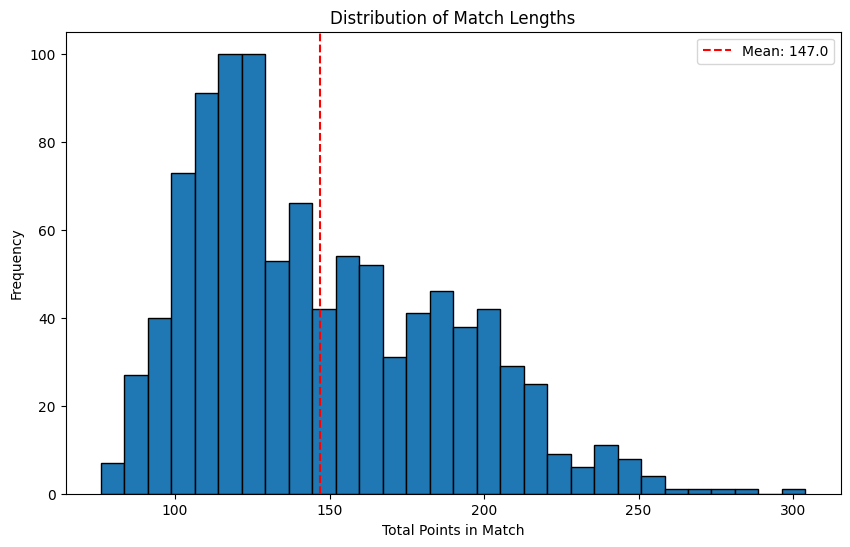

Average match length: 147.0 points
Shortest match: 76 points
Longest match: 304 points


In [37]:
# Now we can analyze the synthetic data!
# For example, let's look at the distribution of match lengths (total points played)

match_lengths = []
for match in matches:
    total_points = 0
    for tennis_set in match.sets:
        for game in tennis_set.games:
            if isinstance(game, Tiebreak):
                total_points += len(game.points)
            else:
                total_points += len(game.points)
    match_lengths.append(total_points)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(match_lengths, bins=30, edgecolor='black')
plt.xlabel('Total Points in Match')
plt.ylabel('Frequency')
plt.title('Distribution of Match Lengths')
plt.axvline(np.mean(match_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(match_lengths):.1f}')
plt.legend()
plt.show()

print(f"Average match length: {np.mean(match_lengths):.1f} points")
print(f"Shortest match: {min(match_lengths)} points")
print(f"Longest match: {max(match_lengths)} points")

In [38]:
# Analyze clutch performance - how often do players win game points vs regular points? (note that this is governed directly by the model parameters; it should be approximately the difference in pressure_skill)
# Extract all points from all matches and categorize them

regular_points_federer_serving = []
game_points_federer_serving = []

for match in matches:
    for tennis_set in match.sets:
        for game in tennis_set.games:
            if isinstance(game, Tiebreak):
                for point in game.points:
                    if point.server.name == "Federer":
                        if point.is_game_point:
                            game_points_federer_serving.append(point.server_won)
                        else:
                            regular_points_federer_serving.append(point.server_won)
            else:
                if game.server.name == "Federer":
                    for point in game.points:
                        if point.is_game_point:
                            game_points_federer_serving.append(point.server_won)
                        else:
                            regular_points_federer_serving.append(point.server_won)

regular_win_pct = sum(regular_points_federer_serving) / len(regular_points_federer_serving) * 100
game_point_win_pct = sum(game_points_federer_serving) / len(game_points_federer_serving) * 100 if game_points_federer_serving else 0

print(f"Federer serving on regular points: {regular_win_pct:.1f}% win rate ({len(regular_points_federer_serving)} points)")
print(f"Federer serving on game points: {game_point_win_pct:.1f}% win rate ({len(game_points_federer_serving)} points)")
print(f"Difference: {game_point_win_pct - regular_win_pct:.1f}%")

Federer serving on regular points: 57.6% win rate (52507 points)
Federer serving on game points: 59.3% win rate (21432 points)
Difference: 1.7%


# Federer Won Only 53% of His Points???
In a famous graduation speech at Dartmouth, recently retired tennis legend Roger Federer, pointed out that, over the course of his career, he won only 53% of the points he played. This seems kind of surprising, since he reached the finals, meaning he won six matches in a row, in 31 of 81 grand slams he competed in (38%). Did he just play a lot better in the grand slams, or is it plausible that he could have a high probability of winning six matches in a row (to reach the finals) even if he had only a slight edge on each point?
- If the probability of winning each point is 53%, what is the probability of winning a game, with standard scoring and no-ad scoring? (Before running the simulation, see if you can make a guess about whether the probability of winning a game will be higher or lower than 53%, and whether the probability is higher or lower with standard or no-ad scoring.)
- Suppose that Feder actually had a 60% chance of winning each point when he served, and a 46% chance of winning each point when his opponent served, what was his probability of winning a set? the probability of winning a match? the probability of winning six matches in a row? More generally, given that Feder was going to win 53% of points overall, would it have been better for him to have a balanced advantage both serving and returning, or would it be better to have a bigger serving advantage and less when returning?


In [17]:
# Question 1: Federer's 53% point winning percentage
# Let's create a player who wins 53% of points overall

# First, let's find the skill levels that give us 53% overall point winning
# We'll test a balanced player (equal serve and return skills)

# For a balanced player winning 53% overall:
# Base probability = 50%, so we need +3% advantage
# This means serve_skill - opponent_return_skill = 3 when serving
# And opponent_serve_skill - return_skill = -3 when returning (losing 47%)

# Let's create two players:
# Federer: slight advantage both serving and returning
# Opponent: average player
federer_53 = Player(serve_skill=3, return_skill=3, pressure_skill=0, name="Federer-53%")
average_opponent = Player(serve_skill=0, return_skill=0, pressure_skill=0, name="Average")

# Verify this gives us 53% point winning
num_sims = 10000
points_won = 0
for _ in range(num_sims):
    # Half the time Federer serves
    point = Point(federer_53, average_opponent)
    if point.simulate():
        points_won += 1
    # Half the time Federer returns
    point = Point(average_opponent, federer_53)
    if not point.simulate():
        points_won += 1

print(f"Verification: Federer wins {points_won/(2*num_sims)*100:.1f}% of points")
print()

# Now simulate games to see game winning percentage
num_sims = 100000
games_won_serving = 0
games_won_returning = 0

for _ in range(num_sims):
    # When Federer serves
    game = Game(federer_53, average_opponent)
    if game.simulate():
        games_won_serving += 1
    
    # When Federer returns
    game = Game(average_opponent, federer_53)
    if not game.simulate():
        games_won_returning += 1

print(f"With 53% point winning:")
print(f"  Game winning % when serving: {games_won_serving/num_sims*100:.1f}%")
print(f"  Game winning % when returning: {games_won_returning/num_sims*100:.1f}%")
print(f"  Overall game winning %: {(games_won_serving + games_won_returning)/(2*num_sims)*100:.1f}%")
print()

# Now simulate Grand Slam matches
num_sims = 1000
matches_won = 0

for _ in range(num_sims):
    match = Match(federer_53, average_opponent, best_of=5)
    if match.simulate():
        matches_won += 1

print(f"  Match winning % (best of 5): {matches_won/num_sims*100:.1f}%")

# Probability of winning 6 matches in a row
match_win_prob = matches_won / num_sims
six_match_prob = match_win_prob ** 6
print(f"  Probability of winning 6 matches in a row: {six_match_prob*100:.1f}%")
print()
print(f"Federer reached the finals in 31 of 81 Grand Slams (38.3%)")
print(f"Our simulation suggests {six_match_prob*100:.1f}% with 53% point winning")
print(f"Conclusion: {'Plausible!' if six_match_prob > 0.30 else 'He likely played better in Grand Slams'}")

Verification: Federer wins 53.2% of points

With 53% point winning:
  Game winning % when serving: 57.1%
  Game winning % when returning: 57.5%
  Overall game winning %: 57.3%

With 53% point winning:
  Game winning % when serving: 57.1%
  Game winning % when returning: 57.5%
  Overall game winning %: 57.3%

  Match winning % (best of 5): 83.4%
  Probability of winning 6 matches in a row: 33.7%

Federer reached the finals in 31 of 81 Grand Slams (38.3%)
Our simulation suggests 33.7% with 53% point winning
Conclusion: Plausible!
  Match winning % (best of 5): 83.4%
  Probability of winning 6 matches in a row: 33.7%

Federer reached the finals in 31 of 81 Grand Slams (38.3%)
Our simulation suggests 33.7% with 53% point winning
Conclusion: Plausible!


In [18]:
# Part 2: Test a range of serve_skill values
# Constraint: serve_skill + return_skill = 6 (to maintain 53% overall)
# We'll vary serve_skill from 3 to 23, and calculate return_skill accordingly

serve_skills = range(3, 32, 2)  # 3 to 32, incrementing by 2
skill_differences = []  # serve_skill - return_skill
six_match_probabilities = []
six_match_std_devs = []  # Standard deviations for confidence intervals

num_sims_per_config = 8000  # Simulations per configuration

print("Testing different skill distributions (all maintain 53% overall point winning):")
print(f"{'Serve':<6} {'Return':<7} {'Difference':<11} {'Match Win %':<12} {'6 Matches %':<12}")
print("-" * 60)

for serve_skill in serve_skills:
    return_skill = 6 - serve_skill
    
    # Create player with this configuration
    player = Player(serve_skill=serve_skill, return_skill=return_skill, 
                   pressure_skill=0, name=f"Fed-{serve_skill}/{return_skill}")
    
    # Simulate matches
    wins = 0
    for _ in range(num_sims_per_config):
        match = Match(player, average_opponent, best_of=5)
        if match.simulate():
            wins += 1
    
    match_win_prob = wins / num_sims_per_config
    six_match_prob = match_win_prob ** 6
    
    # Calculate standard error for the match win probability (binomial proportion)
    # SE = sqrt(p * (1-p) / n)
    match_win_se = np.sqrt(match_win_prob * (1 - match_win_prob) / num_sims_per_config)
    
    # Propagate error to six_match_prob using delta method
    # If Y = X^6, then SE(Y) ≈ |6 * X^5| * SE(X)
    six_match_se = 6 * (match_win_prob ** 5) * match_win_se
    six_match_std_dev = six_match_se * 100  # Convert to percentage
    
    skill_diff = serve_skill - return_skill
    skill_differences.append(skill_diff)
    six_match_probabilities.append(six_match_prob * 100)  # Convert to percentage
    six_match_std_devs.append(six_match_std_dev)
    
    print(f"{serve_skill:<6} {return_skill:<7} {skill_diff:<11} {match_win_prob*100:<12.1f} {six_match_prob*100:<12.2f}")

print()
print(f"Federer's actual Grand Slam finals rate: 38.3% (31 of 81)")
print(f"Best configuration: serve_skill={serve_skills[np.argmax(six_match_probabilities)]}, "
      f"return_skill={6-serve_skills[np.argmax(six_match_probabilities)]} "
      f"with {max(six_match_probabilities):.2f}% probability")

Testing different skill distributions (all maintain 53% overall point winning):
Serve  Return  Difference  Match Win %  6 Matches % 
------------------------------------------------------------
3      3       0           84.5         36.34       
3      3       0           84.5         36.34       
5      1       4           83.9         34.88       
5      1       4           83.9         34.88       
7      -1      8           84.5         36.40       
7      -1      8           84.5         36.40       
9      -3      12          83.4         33.62       
9      -3      12          83.4         33.62       
11     -5      16          83.7         34.45       
11     -5      16          83.7         34.45       
13     -7      20          82.8         32.22       
13     -7      20          82.8         32.22       
15     -9      24          83.6         34.05       
15     -9      24          83.6         34.05       
17     -11     28          82.9         32.37       
17     -11 

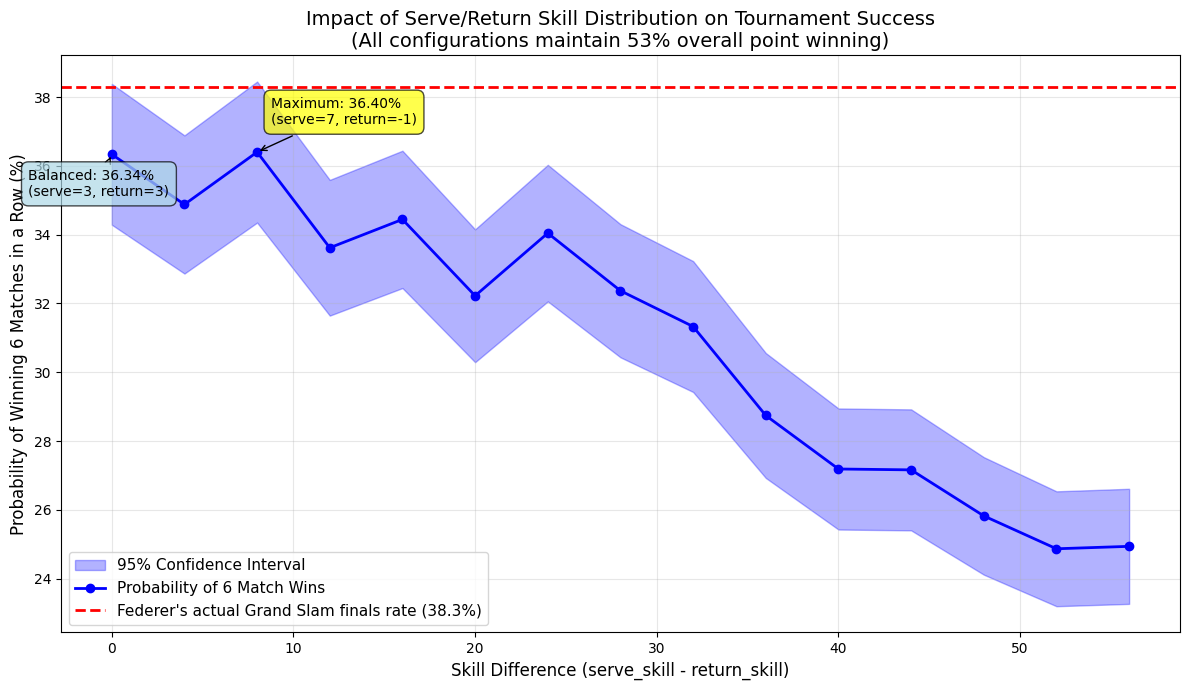


KEY INSIGHTS:
Balanced approach (serve=3, return=3): 36.34%
Best approach (serve=7, return=-1): 36.40%
Improvement: 0.06 percentage points


In [19]:
# Graph the results with confidence intervals
plt.figure(figsize=(12, 7))

# Convert lists to numpy arrays for easier calculation
skill_diffs_array = np.array(skill_differences)
six_match_probs_array = np.array(six_match_probabilities)
six_match_std_array = np.array(six_match_std_devs)

# Calculate 95% confidence intervals (approximately 2 standard errors)
ci_multiplier = 1.96  # For 95% confidence interval
lower_bound = six_match_probs_array - ci_multiplier * six_match_std_array
upper_bound = six_match_probs_array + ci_multiplier * six_match_std_array

# Plot the confidence interval as a shaded region
plt.fill_between(skill_diffs_array, lower_bound, upper_bound, 
                 alpha=0.3, color='blue', label='95% Confidence Interval')

# Plot the main line
plt.plot(skill_differences, six_match_probabilities, 'b-o', linewidth=2, markersize=6, 
         label='Probability of 6 Match Wins')

# Add Federer's actual rate
plt.axhline(y=38.3, color='r', linestyle='--', linewidth=2, 
           label="Federer's actual Grand Slam finals rate (38.3%)")

plt.xlabel('Skill Difference (serve_skill - return_skill)', fontsize=12)
plt.ylabel('Probability of Winning 6 Matches in a Row (%)', fontsize=12)
plt.title('Impact of Serve/Return Skill Distribution on Tournament Success\n(All configurations maintain 53% overall point winning)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add annotation for the maximum
max_idx = np.argmax(six_match_probabilities)
plt.annotate(f'Maximum: {six_match_probabilities[max_idx]:.2f}%\n(serve={serve_skills[max_idx]}, return={6-serve_skills[max_idx]})',
             xy=(skill_differences[max_idx], six_match_probabilities[max_idx]),
             xytext=(10, 20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Add annotation for balanced case
balanced_idx = list(serve_skills).index(3)
plt.annotate(f'Balanced: {six_match_probabilities[balanced_idx]:.2f}%\n(serve=3, return=3)',
             xy=(skill_differences[balanced_idx], six_match_probabilities[balanced_idx]),
             xytext=(-60, -30), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
print(f"Balanced approach (serve=3, return=3): {six_match_probabilities[balanced_idx]:.2f}%")
print(f"Best approach (serve={serve_skills[max_idx]}, return={6-serve_skills[max_idx]}): {six_match_probabilities[max_idx]:.2f}%")
print(f"Improvement: {six_match_probabilities[max_idx] - six_match_probabilities[balanced_idx]:.2f} percentage points")


### Follow-up
It's possible, given that graph, that completely balanced is best, or maybe it's better to have just a little more serving skill than returning skill. Let's run some simulations to find out!

We need to try a much larger sample size for each of the skill distributions close to balanced to get a more precise estimate of the probability of winning six matches in a row. Let's try 100,000 simulations for (+3, +3) and (+7, +1).


In [20]:
# Follow-up: High-precision comparison of balanced vs. slightly server-focused
# Run 100,000 simulations for each configuration to get precise estimates

num_precision_sims = 100000

# Configuration 1: Balanced (serve=3, return=3)
balanced_player = Player(serve_skill=3, return_skill=3, pressure_skill=0, name="Balanced")
balanced_wins = 0

print("Running 100,000 simulations for precise comparison...")
print(f"Configuration 1: Balanced (serve=3, return=3)")

for i in range(num_precision_sims):
    if (i + 1) % 20000 == 0:
        print(f"  Progress: {i + 1}/{num_precision_sims} simulations completed...")
    match = Match(balanced_player, average_opponent, best_of=3)
    if match.simulate():
        balanced_wins += 1

balanced_match_prob = balanced_wins / num_precision_sims
balanced_six_prob = balanced_match_prob ** 6
balanced_se = np.sqrt(balanced_match_prob * (1 - balanced_match_prob) / num_precision_sims)
balanced_six_se = 6 * (balanced_match_prob ** 5) * balanced_se

print(f"  Match win probability: {balanced_match_prob*100:.3f}%")
print(f"  Six match probability: {balanced_six_prob*100:.3f}% ± {1.96 * balanced_six_se * 100:.3f}%")
print()

# Configuration 2: Slightly server-focused (serve=7, return=-1)
server_focused_player = Player(serve_skill=7, return_skill=-1, pressure_skill=0, name="ServerFocused")
server_focused_wins = 0

print(f"Configuration 2: Server-focused (serve=7, return=-1)")

for i in range(num_precision_sims):
    if (i + 1) % 20000 == 0:
        print(f"  Progress: {i + 1}/{num_precision_sims} simulations completed...")
    match = Match(server_focused_player, average_opponent, best_of=3)
    if match.simulate():
        server_focused_wins += 1

server_focused_match_prob = server_focused_wins / num_precision_sims
server_focused_six_prob = server_focused_match_prob ** 6
server_focused_se = np.sqrt(server_focused_match_prob * (1 - server_focused_match_prob) / num_precision_sims)
server_focused_six_se = 6 * (server_focused_match_prob ** 5) * server_focused_se

print(f"  Match win probability: {server_focused_match_prob*100:.3f}%")
print(f"  Six match probability: {server_focused_six_prob*100:.3f}% ± {1.96 * server_focused_six_se * 100:.3f}%")
print()

# Compare the results
print("="*70)
print("COMPARISON:")
print("="*70)
print(f"Balanced (3, 3):")
print(f"  Six match probability: {balanced_six_prob*100:.3f}% (95% CI: [{balanced_six_prob*100 - 1.96*balanced_six_se*100:.3f}%, {balanced_six_prob*100 + 1.96*balanced_six_se*100:.3f}%])")
print()
print(f"Server-focused (7, -1):")
print(f"  Six match probability: {server_focused_six_prob*100:.3f}% (95% CI: [{server_focused_six_prob*100 - 1.96*server_focused_six_se*100:.3f}%, {server_focused_six_prob*100 + 1.96*server_focused_six_se*100:.3f}%])")
print()

difference = server_focused_six_prob - balanced_six_prob
difference_se = np.sqrt(balanced_six_se**2 + server_focused_six_se**2)
z_score = difference / difference_se

print(f"Difference: {difference*100:.3f} percentage points")
print(f"Standard error of difference: {difference_se*100:.3f} percentage points")
print(f"Z-score: {z_score:.2f}")
print()

if abs(z_score) > 1.96:
    winner = "Server-focused" if difference > 0 else "Balanced"
    print(f"Conclusion: {winner} is SIGNIFICANTLY better (p < 0.05)")
else:
    print(f"Conclusion: No significant difference detected between the two approaches")
print(f"             (The confidence intervals {'do not overlap' if abs(z_score) > 1.96 else 'overlap'})")

Running 100,000 simulations for precise comparison...
Configuration 1: Balanced (serve=3, return=3)
  Progress: 20000/100000 simulations completed...
  Progress: 40000/100000 simulations completed...
  Progress: 60000/100000 simulations completed...
  Progress: 80000/100000 simulations completed...
  Progress: 100000/100000 simulations completed...
  Match win probability: 79.050%
  Six match probability: 24.401% ± 0.467%

Configuration 2: Server-focused (serve=7, return=-1)
  Progress: 20000/100000 simulations completed...
  Progress: 40000/100000 simulations completed...
  Progress: 60000/100000 simulations completed...
  Progress: 80000/100000 simulations completed...
  Progress: 100000/100000 simulations completed...
  Match win probability: 78.591%
  Six match probability: 23.563% ± 0.457%

COMPARISON:
Balanced (3, 3):
  Six match probability: 24.401% (95% CI: [23.934%, 24.868%])

Server-focused (7, -1):
  Six match probability: 23.563% (95% CI: [23.106%, 24.021%])

Difference: -0

## Should You Hire a Sports Psychologist?
Suppose you are a coach for Joe Average, and you want to give him a better chance of winning against a balanced Federer. During the short off-season, you have a chance to either improve his serve by +3, or hire a sports psychologist who will improve his ability to handle high-pressure points, improving his clutch by +3. Which of these two options would you choose to give Joe Average?



In [21]:
# Analysis: Joe Average gets +3 clutch OR +3 serve
# Compare impact on match win probability vs Federer

num_sims = 40000
federer = Player(serve_skill=5, return_skill=1, pressure_skill=0, name="Federer")

# Joe with +3 clutch
joe_clutch = Player(serve_skill=2, return_skill=-2, pressure_skill=3, name="JoeAvg_clutch3")
wins_clutch = 0
for _ in range(num_sims):
    match = Match(joe_clutch, federer, best_of=3)
    if match.simulate():
        wins_clutch += 1
match_win_prob_clutch = wins_clutch / num_sims
se_clutch = np.sqrt(match_win_prob_clutch * (1 - match_win_prob_clutch) / num_sims)

# Joe with +3 serve
joe_serve = Player(serve_skill=5, return_skill=-2, pressure_skill=0, name="JoeAvg_serve5")
wins_serve = 0
for _ in range(num_sims):
    match = Match(joe_serve, federer, best_of=3)
    if match.simulate():
        wins_serve += 1
match_win_prob_serve = wins_serve / num_sims
se_serve = np.sqrt(match_win_prob_serve * (1 - match_win_prob_serve) / num_sims)

print(f"Joe Average with +3 clutch:")
print(f"  Match win probability: {match_win_prob_clutch*100:.2f}% ± {1.96*se_clutch*100:.2f}%")
print()
print(f"Joe Average with +3 serve:")
print(f"  Match win probability: {match_win_prob_serve*100:.2f}% ± {1.96*se_serve*100:.2f}%")

# Summary
if match_win_prob_clutch > match_win_prob_serve:
    print(f"Clutch improvement is better for match success.")
else:
    print(f"Serve improvement is better for match success.")

Joe Average with +3 clutch:
  Match win probability: 34.00% ± 0.46%

Joe Average with +3 serve:
  Match win probability: 34.44% ± 0.47%
Serve improvement is better for match success.


#### Follow-up
Let's try to look at it a bit analytically. What fraction of the points are game-points and what fraction of points are in clutch games? If we add those two together, we will know the average effection of the pressure_skill parameter. If it's more than 0.5, then it will be better to improve clutch than to improve serve.

In [22]:
# Analysis: What fraction of points are game points and what fraction of games are clutch games?
# We'll simulate a bunch of matches and then count it up.
num_sims = 10000
federer = Player(serve_skill=3, return_skill=3, pressure_skill=0, name="Federer")
joe = Player(serve_skill=0, return_skill=0, pressure_skill=0, name="Joe Average")

matches = [Match(joe, federer, best_of=3) for _ in range(num_sims)]
for match in matches:
    match.simulate()

# collect all the points. Count how many are game points and how many are in clutch games
total_points = 0
game_points = 0
clutch_game_points = 0

for match in matches:
    for tennis_set in match.sets:
        for game in tennis_set.games:
            is_clutch = isinstance(game, Tiebreak) or game.is_clutch_game
            for point in game.points:
                total_points += 1
                if is_clutch:
                    clutch_game_points += 1
                if point.is_game_point:
                    game_points += 1

print(f"Total points simulated: {total_points}")
print(f"Total game points: {game_points} ({game_points/total_points*100:.2f}%)")
print(f"Total points in clutch games: {clutch_game_points} ({clutch_game_points/total_points*100:.2f}%)")
print(f"expected boost from clutch skill: {(game_points + clutch_game_points)/total_points:.2f}%")
                    


Total points simulated: 1552696
Total game points: 455103 (29.31%)
Total points in clutch games: 273840 (17.64%)
expected boost from clutch skill: 0.47%


#### Analysis
The expected impact of one additional pressure_skill point is almost 0.5, so it makes sense that improving clutch by +3 is almost as good as improving serve by +3.

## When a big server faces a big server, how often do they go to a tie-break? How big a difference in serving skill is needed to make tie-breaks the most common set outcome?

Fraction of sets that go to a tie-break (big server vs big server): 37.20%


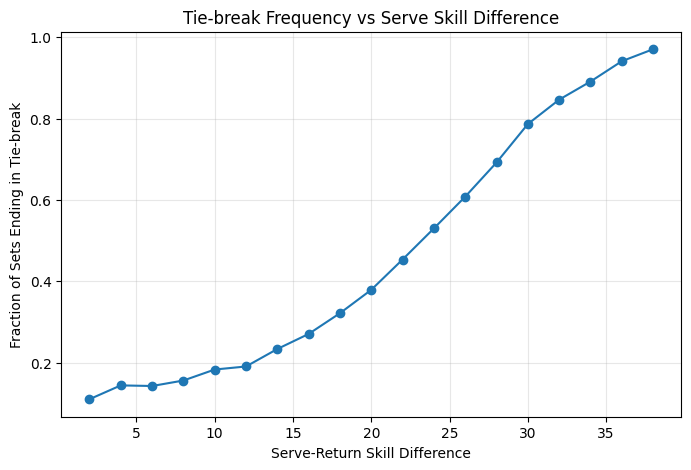

In [23]:
# Analysis: Tie-break frequency for big servers
# Simulate sets with two big servers and count tie-breaks

num_sets = 2000
set_tiebreaks = 0
set_scores = []

# Big server skills
big_server1 = Player(serve_skill=20, return_skill=0, pressure_skill=0, name="BigServer1")
big_server2 = Player(serve_skill=20, return_skill=0, pressure_skill=0, name="BigServer2")

sets = [Set(big_server1, big_server2) for _ in range(num_sets)]
for tennis_set in sets:
    tennis_set.simulate()

fraction_tiebreak = len([s for s in sets if isinstance(s.games[-1], Tiebreak)]) / num_sets
print(f"Fraction of sets that go to a tie-break (big server vs big server): {fraction_tiebreak*100:.2f}%")

# Now vary serve skill difference to see when tie-breaks become most common
skills = range(2, 40, 2)
tiebreak_freqs = []
for skill in skills:
    p1 = Player(serve_skill=skill, return_skill=0, pressure_skill=0, name="Server1")
    p2 = Player(serve_skill=skill, return_skill=0, pressure_skill=0, name="Server2")
    sets = [Set(p1, p2) for _ in range(num_sets)]
    for tennis_set in sets:
        tennis_set.simulate()
    fraction_tiebreak = len([s for s in sets if isinstance(s.games[-1], Tiebreak)]) / num_sets
    tiebreak_freqs.append(fraction_tiebreak)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(skills, tiebreak_freqs, 'o-')
plt.xlabel('Serve-Return Skill Difference')
plt.ylabel('Fraction of Sets Ending in Tie-break')
plt.title('Tie-break Frequency vs Serve Skill Difference')
plt.grid(True, alpha=0.3)
plt.show()


#### Analysis

It looks like we need a huge difference in server vs. returner skill in order to have more than 50% of sets go to a tie-break. Serve-return difference of about 24 points, meaning that the server wins about 75% of their service points, is needed to have more than half the sets go to a tie-break. Even with a 20-point difference (about 70% of service points won), only about 40% of sets go to a tie-break.